# Composite vector space tutorial

In romtools, a composite vector space refers to multiple vector spaces that are stitched together into one vector space. 
The use case of a composite vector space is if you want to have independent basis functions for different DOFs (e.g., mass, momentum).

In this tutorial you will learn:


- How to construct a composite vector space that comprises several vector spaces stiched together



## Modules
Here are the relevant modules for this example.

In [8]:
%%capture
import romtools
import numpy as np
from matplotlib import pyplot as plt
from romtools import vector_space, composite_vector_space

## Snapshots
First, we load in snapshots from a FOM. We use pre-computed snapshots of the [1D Euler equations](https://pressio.github.io/pressio-demoapps/euler_1d_smooth.html) obtained using pressio-demo-apps.

In [9]:
snapshots = np.load('snapshots.npz')['snapshots']

## The snapshots are in tensor form:
n_vars, nx, nt = snapshots.shape

Along the first axis we have snapshots of mass ($\rho$), momentum ($\rho u$), and energy ($\rho E$), respectively.

Note that romtools works with [tensor forms](https://pressio.github.io/rom-tools-and-workflows/romtools/vector_space.html).

## Basis Creation
In this example, we make a composite vector space where each state variable in our snapshot matrix has its own basis. (This is often times referred to as "vector POD" in the literature).

Like the last tutorial, let's create a [truncater](https://pressio.github.io/rom-tools-and-workflows/romtools/vector_space/utils/truncater.html) that controls for how we want to truncate our basis. This truncater is set to truncate the number of modes to capture 99.9% of the cumulative energy.

In [10]:
my_truncater = vector_space.utils.EnergyBasedTruncater(0.999)

Now, let's construct a vector space using POD for the **density variable only**.

In [11]:
my_vector_space_rho = vector_space.VectorSpaceFromPOD(snapshots[0:1],truncater=my_truncater)

#Let's look a the shape of our vector space:
print('The vector space for rho is of shape: ', my_vector_space_rho.extents())

The vector space for rho is of shape:  (1, 500, 4)


Let's make vector spaces for the next two variables (momentum and energy)

In [12]:
my_vector_space_rhoU = vector_space.VectorSpaceFromPOD(snapshots[1:2],truncater=my_truncater)
print('The vector space for rhoU is of shape: ', my_vector_space_rhoU.extents())
my_vector_space_rhoE = vector_space.VectorSpaceFromPOD(snapshots[2:3],truncater=my_truncater)
print('The vector space for rhoE is of shape: ', my_vector_space_rhoE.extents())

The vector space for rhoU is of shape:  (1, 500, 31)
The vector space for rhoE is of shape:  (1, 500, 6)


Now, we will create a composite vector space that stiches these three vector spaces together:

In [13]:
my_composite_vector_space = composite_vector_space.CompositeVectorSpace([my_vector_space_rho,my_vector_space_rhoU,my_vector_space_rhoE])

# Let's look at the size of this vector space:
print('The composite vector space is of shape: ' , my_composite_vector_space.extents())


The composite vector space is of shape:  [  3 500  41]


We see that the number of basis vectors is the sum of the individual vector spaces.

### Viewing the Basis
Let's view the sparsity pattern if we view this as a tradititional basis matrix.

First, let's grab the basis.

In [14]:
composite_basis = my_composite_vector_space.get_basis()

And then reshape it into a matrix. Note all of romtools uses order 'C' for reshaping.

In [17]:
basis_matrix = np.reshape(composite_basis,(composite_basis.shape[0]*composite_basis.shape[1],composite_basis.shape[2]),'C')

Finally, we can view the sparsity pattern of the basis.

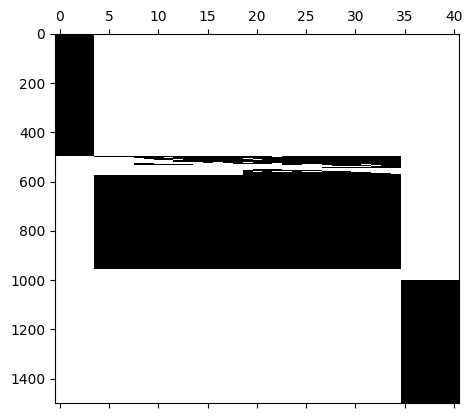

In [16]:
plt.spy(basis_matrix)
plt.gca().set_aspect(0.025)
plt.show()

We see the basis has a block structure. This means that each state variable will effectively have their own reduced coordinates.